In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as pt

from tensorflow.keras import layers
from tensorflow.keras import activations as act
from tensorflow.keras.datasets.cifar10 import load_data

In [2]:
(x_train, y_train), (x_test, y_test) = load_data()

print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(np.max(y_train) - np.min(y_train) + 1))

shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10


In [3]:
n_train = x_train.shape[0]
n_test = x_test.shape[0]
n_cls = np.max(y_train) - np.min(y_train) + 1

rand_perm = np.random.permutation(n_train)

x_train = x_train[rand_perm]
y_train = y_train[rand_perm]

# x_train = x_train[..., np.newaxis]

y_train = tf.one_hot(y_train, depth=n_cls, on_value=1, off_value=0)
y_test = tf.one_hot(y_test, depth=n_cls, on_value=1, off_value=0)

y_train = np.moveaxis(y_train, 2, 1)
y_test = np.moveaxis(y_test, 2, 1)

y_train = np.squeeze(y_train, axis=2)
y_test = np.squeeze(y_test, axis=2)

X = x_train[:40000]
y = y_train[:40000]

x_val = x_train[40000:]
y_val = y_train[40000:]

train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validate = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [4]:
print('Shape of x_train: ' + str(X.shape))
print('Shape of y_train: ' + str(y.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_train: (40000, 32, 32, 3)
Shape of y_train: (40000, 10)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 10)


In [5]:
IMG_SIZE=32

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [6]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomContrast(0.7)
])

In [7]:
batch_size = 64
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
    # Resize and rescale all datasets
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    # Batch all datasets
    ds = ds.batch(batch_size)

    # Use data augmentation only on the training set
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=AUTOTUNE)

    # Use buffered prefecting on all datasets
    return ds.prefetch(buffer_size=AUTOTUNE)


In [8]:
train = prepare(train, shuffle=False, augment=True)
validate = prepare(validate)
test = prepare(test)

print(f"Train: {train}\n{len(train)*batch_size}")
print(f"Val: {validate}\n{len(validate)*batch_size}")
print(f"Test: {test}\n{len(test)*batch_size}")

Train: <PrefetchDataset shapes: ((None, 32, 32, 3), (None, 10)), types: (tf.float32, tf.int32)>
50048
Val: <PrefetchDataset shapes: ((None, 32, 32, 3), (None, 10)), types: (tf.float32, tf.int32)>
10048
Test: <PrefetchDataset shapes: ((None, 32, 32, 3), (None, 10)), types: (tf.float32, tf.int32)>
10048


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor([0 0 0 0 0 0 0 0 1 0], shape=(10,), dtype=int32)


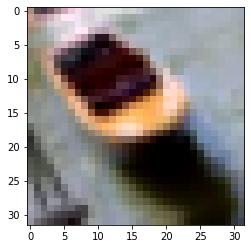

In [9]:
image, label = next(iter(train))
print(label[0])
pt.imshow(image[0,...], cmap='gray')

In [10]:
inp = layers.Input(shape=(32, 32, 3))

x = layers.Conv2D(32, (3, 3), padding="same")(inp)
y = layers.BatchNormalization()(x)
y = layers.Activation(layers.LeakyReLU())(y)

#--------------------------------------------------------
x = layers.Conv2D(64, (3, 3), padding="same")(y)
y = layers.BatchNormalization()(x)
y = layers.Activation(layers.LeakyReLU())(y)
y = layers.Conv2D(64, (3, 3), padding='same')(y)
y = layers.BatchNormalization()(y)
y = layers.Activation(layers.LeakyReLU())(y)

x = layers.Add()([x, y])
#--------------------------------------------------------
x = layers.Conv2D(64, (3, 3), padding="same")(x)
y = layers.BatchNormalization()(x)
y = layers.Activation(layers.LeakyReLU())(y)
y = layers.Conv2D(64, (3, 3), padding='same')(y)
y = layers.BatchNormalization()(y)
y = layers.Activation(layers.LeakyReLU())(y)

x = layers.Add()([x, y])
#--------------------------------------------------------
x = layers.Conv2D(64, (3, 3), padding="same")(x)
y = layers.BatchNormalization()(x)
y = layers.Activation(layers.LeakyReLU())(y)
y = layers.Conv2D(64, (3, 3), padding='same')(y)
y = layers.BatchNormalization()(y)
y = layers.Activation(layers.LeakyReLU())(y)

x = layers.Add()([x, y])
#--------------------------------------------------------
x = layers.Conv2D(64, (3, 3), padding="same")(x)
y = layers.BatchNormalization()(x)
y = layers.Activation(layers.LeakyReLU())(y)
y = layers.Conv2D(64, (3, 3), padding='same')(y)
y = layers.BatchNormalization()(y)
y = layers.Activation(layers.LeakyReLU())(y)

x = layers.Add()([x, y])
#--------------------------------------------------------
x = layers.Conv2D(64, (3, 3), padding="same")(x)
y = layers.BatchNormalization()(x)
y = layers.Activation(layers.LeakyReLU())(y)
y = layers.Conv2D(64, (3, 3), padding='same')(y)
y = layers.BatchNormalization()(y)
y = layers.Activation(layers.LeakyReLU())(y)

x = layers.Add()([x, y])
#--------------------------------------------------------
x = layers.Conv2D(64, (3, 3), padding="same")(x)
y = layers.BatchNormalization()(x)
y = layers.Activation(layers.LeakyReLU())(y)
y = layers.Conv2D(64, (3, 3), padding='same')(y)
y = layers.BatchNormalization()(y)
y = layers.Activation(layers.LeakyReLU())(y)

x = layers.Add()([x, y])
#--------------------------------------------------------
# x = layers.Conv2D(64, (3, 3), padding="same")(x)
# y = layers.BatchNormalization()(x)
# y = layers.Activation(layers.LeakyReLU())(y)
# y = layers.Conv2D(64, (3, 3), padding='same')(y)
# y = layers.BatchNormalization()(y)
# y = layers.Activation(act.relu)(y)

# x = layers.Add()([x, y])
# #--------------------------------------------------------
# x = layers.Conv2D(64, (3, 3), padding="same")(x)
# y = layers.BatchNormalization()(x)
# y = layers.Activation(layers.LeakyReLU())(y)
# y = layers.Conv2D(64, (3, 3), padding='same')(y)
# y = layers.BatchNormalization()(y)
# y = layers.Activation(act.relu)(y)

# x = layers.Add()([x, y])
# #--------------------------------------------------------

x = layers.AveragePooling2D((2, 2))(x)

z = layers.Flatten()(x)
z = layers.Dense(64)(z)
z = layers.Activation(layers.LeakyReLU())(z)

z = layers.Dropout(0.25)(z)

z = layers.Dense(10)(z)
z = layers.Activation(act.softmax)(z)

In [11]:
model = tf.keras.models.Model(inputs=inp, outputs=z)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

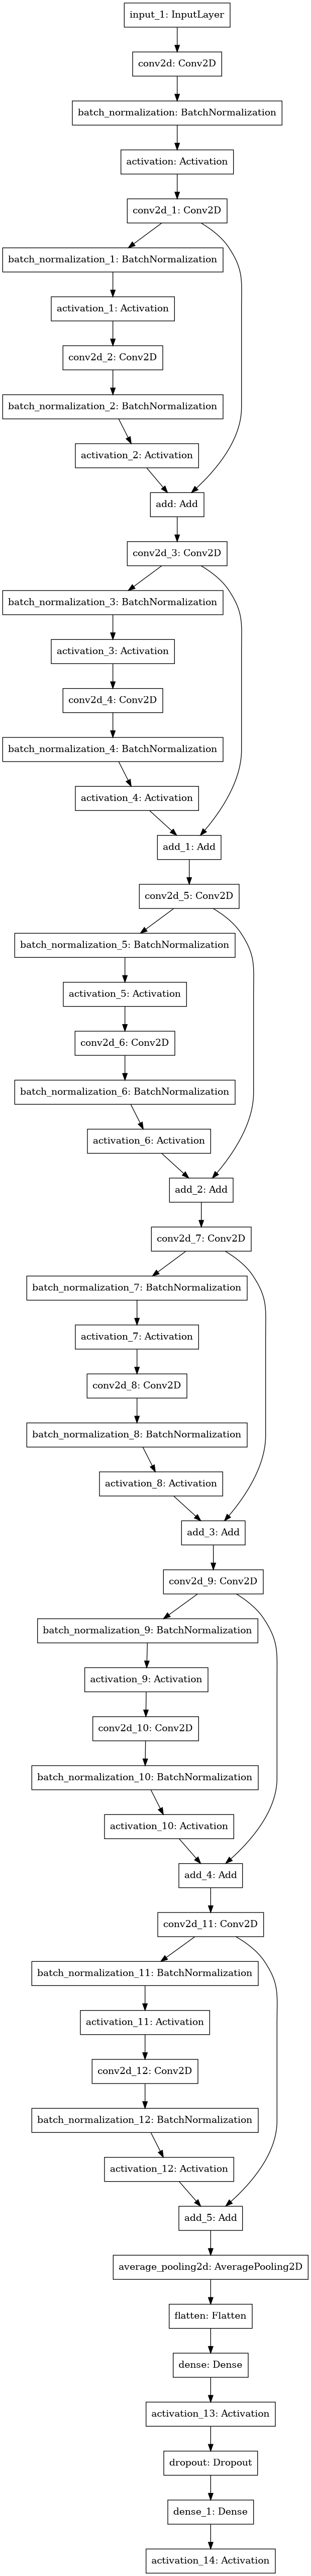

In [13]:
tf.keras.utils.plot_model(model, to_file="skip_connection_graph.png")

In [14]:
model.compile(tf.keras.optimizers.RMSprop(lr=0.00001),
                loss='categorical_crossentropy',
                 metrics=['accuracy']) 
# we have an extremely balanced dataset so classification accuracy is valid

In [15]:
history = model.fit(train,
         epochs=25,
         validation_data=validate)

Epoch 1/25
782/782 [==============================] - 42s 50ms/step - loss: 2.4624 - accuracy: 0.2032 - val_loss: 1.8498 - val_accuracy: 0.3268
Epoch 2/25
782/782 [==============================] - 39s 50ms/step - loss: 1.9622 - accuracy: 0.2974 - val_loss: 1.7311 - val_accuracy: 0.3671
Epoch 3/25
782/782 [==============================] - 39s 50ms/step - loss: 1.8674 - accuracy: 0.3303 - val_loss: 1.6828 - val_accuracy: 0.3919
Epoch 4/25
782/782 [==============================] - 39s 50ms/step - loss: 1.8176 - accuracy: 0.3453 - val_loss: 1.6682 - val_accuracy: 0.3992
Epoch 5/25
782/782 [==============================] - 40s 51ms/step - loss: 1.7634 - accuracy: 0.3656 - val_loss: 1.6216 - val_accuracy: 0.4213
Epoch 6/25
782/782 [==============================] - 41s 53ms/step - loss: 1.7283 - accuracy: 0.3800 - val_loss: 1.5672 - val_accuracy: 0.4337
Epoch 7/25
782/782 [==============================] - 41s 53ms/step - loss: 1.6996 - accuracy: 0.3903 - val_loss: 1.5650 - val_accuracy:

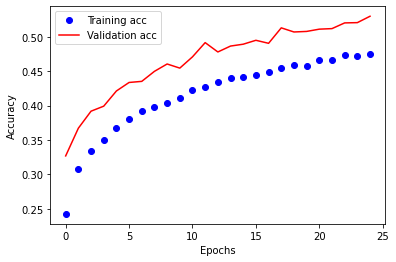

In [16]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

pt.plot(epochs, acc, 'bo', label='Training acc')
pt.plot(epochs, val_acc, 'r', label='Validation acc')
pt.xlabel('Epochs')
pt.ylabel('Accuracy')
pt.legend()
pt.show()



In [17]:
# full_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# print(len(full_train))
# full_batched_train = full_train.batch(32)

In [18]:
# model.compile(tf.keras.optimizers.RMSprop(lr=0.0001),
#                 loss='categorical_crossentropy',
#                  metrics=['accuracy']) 
# # we have an extremely balanced dataset so classification accuracy is valid

In [19]:
# history = model.fit(batched_train,
#          epochs=10,
#          validation_data=(x_val, y_val))

In [20]:
# results = model.evaluate(x_test, y_test, batch_size=32)
# print(f"Loss = {results[0]}")
# print(f"Accuracy = {results[1]}")